In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from deepthink.optimizers import SGD, NAG, AdaGrad, RMSProp, Adam

In [2]:
# Change default line-width setting from 1.5 to 2
import matplotlib as mpl

mpl.rcParams["lines.linewidth"] = 2

# Optimizer Visualization

The purpose of this notebook is to compare different optimizers by visualizing their training performance on a two-dimensional problem. We will look at how momentum affects stochastic gradient descent before comparing different optimizers. By doing so we can get a better understanding of how they work and the differences between them.

We will use the Beale function as our 2D test function. [This Wikipedia page on Test functions](https://en.wikipedia.org/wiki/Test_functions_for_optimization) explains a bit more about test functions for optimization. This is a convex test function with a global minimum at (3.0, 0.5) and has the form:

$f(x, y) = (1.5-x+xy)^2 + (2.25-x+xy^2)^2 + (2.625-x+xy^3)^2$

It must be stated that performing gradient descent on a deterministic test function is different from performing gradient descent in normal machine learning. Usually the global minima is unknown and the goal of optimization is to alter the weights & biases to obtain this by minimizing loss. Here the function is already known and we are only interested in how the optimizer performs updates. Despite this difference we can still gain intuition about how the optimizer algorithms operate. 

### References
- [This gives a good overview of different optimization algorithms](http://ruder.io/optimizing-gradient-descent/)
- [This was very useful, some of the code is adapted from this](http://physics.bu.edu/~pankajm/ML-Notebooks/HTML/NB2_CIV-gradient_descent.html)
- [This is a good introduction to optimizers](https://cs231n.github.io/optimization-1/)
- [This was also useful](https://emiliendupont.github.io/2018/01/24/optimization-visualization/)

In [3]:
# Helper functions


def beales_function(x, y):
    """
    Return Beale function for x and y coordinates.

    Both x and y should be 1D arrays of equal length.
    Returns Beale's function for the given input, i.e.
    the z-dimension if visualizing. The minima of the
    function is at (3.0, 0.5). For more information on
    Beale's function see:
    https://en.wikipedia.org/wiki/Test_functions_for_optimization

    Parameters
    ----------
    x : numpy.array
        One dimensional array of x-axis coordinates
    y : numpy.array
        One dimensional array of y-axis coordinates

    Returns
    -------
    np.array
        One dimensional array of Beale function of x and y
        coordinates, ie the z-coordinates.
    """
    return (
        np.square(1.5 - x + x * y)
        + np.square(2.25 - x + x * y**2)
        + np.square(2.625 - x + x * y**3)
    )


def grad_beales_function(x, y):
    """
    Return the gradient/derivative of Beale function
    for two arrays of x & y coords.
    """
    grads_x = 2 * (1.5 - x + x * y) * (-1 + y) \
              + 2 * (2.25 - x + x * y**2) * (-1 + y**2) \
              + 2 * (2.625 - x + x * y**3) * (-1 + y**3)
    
    grads_y = 2 * (1.5 - x + x * y) * x \
              + 4 * (2.25 - x + x * y**2) * x * y \
              + 6 * (2.625 - x + x * y**3) * x * y**2
    grads = np.array([grads_x, grads_y])
    return grads


def beales_function_contour(figsize=(10, 6), colormap="turbo"):
    """
    Plot Beales function using contour plot. Also adds a
    marker at the minima (3.0, 0.5). Displays values
    from -4.5 to 4.5 on both axes.

    Parameters
    ----------
    figsize : tuple,default=(12, 8)
        The figure-size to use for the visualization.
        Should be a tuple of integers: (width, height).
    colormap : str,default='turbo'
        The matplotlib colormap to use for the image.

    Returns
    -------
    fig : pyplot.figure
        The figure to display
    ax : pyplot.axis
        Axes with Beales function contour plot
    """
    # Obtain x, y and z coordinates
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    z = beales_function(x, y)

    fig, ax = plt.subplots(figsize=figsize)
    # Use x,y & z arrays as dimensions to create contour plot
    contour = ax.contour(
        x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=colormap
    )
    # Add a black star to mark the global minima
    ax.plot(3, 0.5, "k*", markersize=15)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))

    return fig, ax


def plot_trajectory(ax, trajectory, color, label=None):
    """
    Plot an optimizer's training history as trajectory
    on a 2D surface.

    Parameters
    ----------
    ax : AxesSubplot
        The Axes object to plot the trajectory on.
    trajectory : array_like
        A two-dimensional array where each element represents
        the x & y position after one batch of training.
    color : str
        The string representing matplotlib color to use.
    label : str,default=None
        Optional argument, the label to display for this
        trajectory in the legend.

    Returns
    -------
    ax : AxesSubplot
        Axes with the trajectory plotted on it.
    """
    # Unpack x & y values
    xs = trajectory[:, 0]
    ys = trajectory[:, 1]
    if label:
        ax.plot(xs, ys, color=color, label=label)
    else:
        ax.plot(xs, ys, color=color)
    # Add a marker at optimizers last position
    ax.plot(xs[-1], ys[-1], ">", color=color, markersize=14)
    return ax

### Beale's function 2D contour plot

Below we show the contour plot representing the Beale function. The global minima at (3.0, 0.5) is indicated by the black star. 

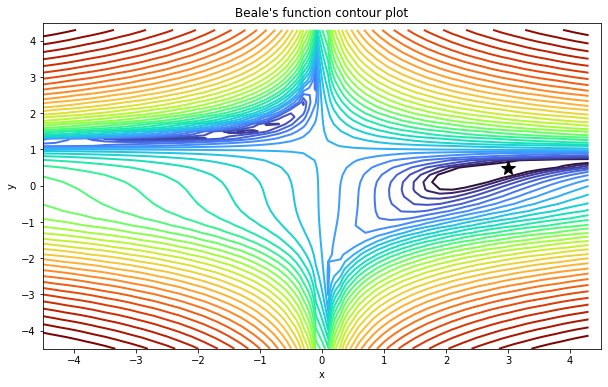

In [4]:
# Show Beale's function
fig, ax = beales_function_contour()

plt.title("Beale's function contour plot")
plt.show()

## Gradient Descent

Gradient descent is an optimization algorithm used to find the minimum of a function. It is an iterative algorithm that starts with an initial set of parameter values and improves them gradually, eventually converging on the optimal set of parameters that minimize the function. 

Here's how it works:

- Initialize the parameters of the model (e.g., weights and biases of a neural network).
- Calculate the loss function (e.g., mean squared error) for the current set of parameters on the training data.
- Calculate the gradients of the loss function with respect to the model parameters.
- Update the parameters in the opposite direction of the gradients, with a learning rate that determines the size of the step taken.
- Repeat steps 2-4 until the loss function is minimized or a maximum number of iterations is reached.

The key idea behind gradient descent is that the loss function is a continuous, differentiable function that has a global minimum (or at least a local minimum that is close enough to the global minimum). The algorithm takes steps in the direction that reduces the loss, and it does so by using the gradients of the loss function to determine the direction of the step. The learning rate determines the size of the step taken, and it is important to choose a learning rate that is not too large (which can result in overshooting the minimum) or too small (which can result in slow convergence).

The gradient descent update can be written as:
$$
\theta_{t+1}= \theta_t - \eta_t \nabla_\theta E(\theta)
$$

Where $\theta$ is the model parameters, $\eta$ the learning rate and $\nabla_\theta E(\theta)$ is the gradients of the loss w.r.t to the parameters.

### Gradient descent with momentum

Momentum is a technique that can be used to accelerate the convergence of gradient descent and reduce the oscillation of the loss function near the minimum. It works by adding a fraction of the update from the previous iteration to the current update, which can help the algorithm "carry through" with the update and make more progress towards the minimum. Here's how gradient descent with momentum works:

- Initialize the parameters of the model and the momentum variable 'v' to zero.
- Calculate the gradients of the loss function with respect to the model parameters.
- Update the momentum variable: v = beta * v + (1 - beta) * gradient, where beta is the momentum hyperparameter (usually set to a value between 0.8 and 0.999).
- Update the parameters: parameter = parameter - learning_rate * v.
- Repeat steps 2-4 until the loss function is minimized or a maximum number of iterations is reached.

The momentum hyperparameter 'beta' determines the fraction of the previous update that is carried over to the current update. A larger value of beta means that the update will be more heavily influenced by the previous update, which can help the algorithm make more progress and converge faster. However, if beta is set too high, it can also cause the algorithm to oscillate and take longer to converge. It is generally a good idea to experiment with different values of beta to find the one that works best for a given problem.

Momentum can help a great deal with noisy, stochastic data where there may be many local minima. We can write the gradient descent with momentum update as:

\begin{align} 
\begin{split} 
v_t &= \gamma v_{t-1} + \eta \nabla_\theta J( \theta) \\ 
\theta &= \theta - v_t 
\end{split} 
\end{align}

Where $\gamma$ is the momentum parameter. The only difference from standard gradient descent is the addition of the momentum term.

## Comparing SGD with and without momentum

It is worth emphasizing here that performing gradient descent on this surface is very different to gradient descent on a loss function in machine learning. In machine learning we use neural networks as [universal function approximators](https://en.wikipedia.org/wiki/Universal_approximation_theorem) however in this instance we already know the function and are only interested in how the optimizers perform.

So in practice this means that instead of updating a model's weights & biases we only care about how the updates affect the gradient estimation. So we use a dummy Layer class and instead of having weights and biases the "weights" in this layer are the current x & y coordinates and the updates represent the change in the current position. The dummy Layer class contains bias however this is only to be compatible with the Optimizer classes, no updates are made to the bias values. 

In [5]:
class Layer:
    """
    Dummy layer used for visualizing optimization functions.

    The "weights" for this layer are the coordinates and the
    optimizer updates these each step. Bias arrays are
    initialized to allow functionality with the optimzer
    but are not updated.
    """

    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias
        self.dweights = np.zeros(self.weights.shape)
        self.dbiases = np.zeros(self.bias.shape)
        # Initialize arrays to store optimizer momentum values
        self.weight_momentum = np.zeros(self.weights.shape)
        self.bias_momentum = np.zeros(self.bias.shape)
        # Initialize arrays to store optimizer gradient cache
        self.weight_grad_cache = np.zeros(self.weights.shape)
        self.bias_grad_cache = np.zeros(self.weights.shape)


def train_optimizer(optimizer, pos, n_epochs=5000, noise=0.0):
    """
    Train an optimizer on Beale's function.

    Parameters
    ----------
    optimzier : any BaseOptimizer sub-class
        An instantiated optimizer to use for training.
    pos : np.array
        Starting position coordinates on Beale's function
        as a 1D array of integers, [x, y].
    n_epochs : int,default=5000
        The number of epochs to train the optimizer.
    noise : float,default=0.0
        Controls the amount of random noise to add to
        the gradients.

    Returns
    -------
    trajectory : np.array
        A Numpy array representing the x & y coordinates
        at each update.
    """
    layer = Layer(pos, np.zeros(2))
    layers = [layer]
    optimizer.initialize(layers)
    # Create an array to track the trajectory of coordinates
    trajectory = np.zeros((n_epochs, 2))
    for i in range(n_epochs):
        # Add current position to trajectory
        trajectory[i] = pos
        # Get current gradient
        grads = grad_beales_function(*pos)
        if noise > 0.0:
            noise_vals = 1 + noise * np.random.randn(2)
            optimizer.layers[0].dweights = grads * noise_vals
        else:
            optimizer.layers[0].dweights = grads

        optimizer.update()
    return trajectory

In [6]:
# Define hyperparameters
learning_rate = 1e-5
n_epochs = 5000
# Pyplot colors to cycle through
colors = ("b", "r", "g", "c", "y", "m")
# start position
pos = np.array([4.0, 3.0])

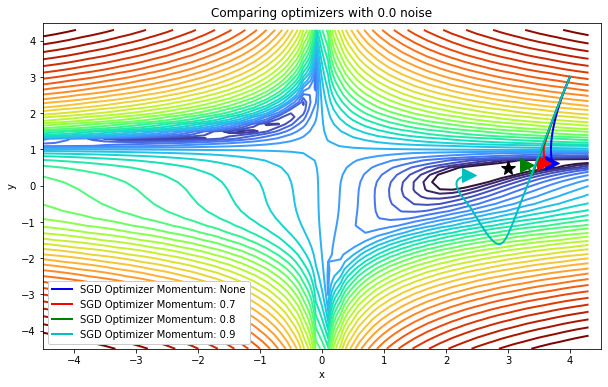

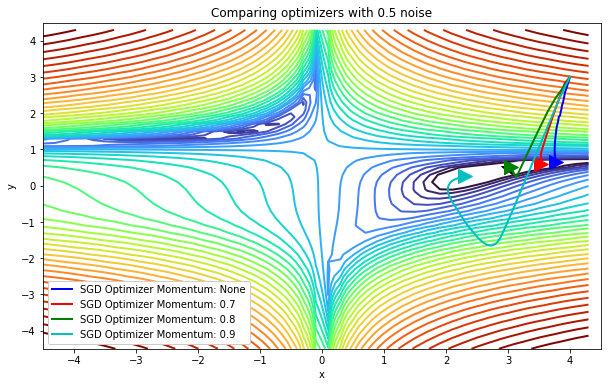

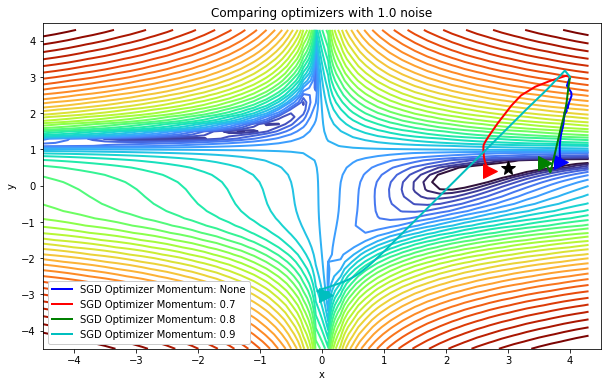

In [7]:
for noise in [0.0, 0.5, 1.0]:
    # Plot beales function
    fig, ax = beales_function_contour()
    # Iterate through momentum values and plot on same figure
    for i, momentum in enumerate((None, 0.7, 0.8, 0.9)):
        opt = SGD(learning_rate, momentum=momentum)
        # Train optimizer to get the training history as trajectory
        trajectory = train_optimizer(opt, pos.copy(), n_epochs=n_epochs, noise=noise)
        ax = plot_trajectory(
            ax, trajectory, colors[i], f"{str(opt)} Momentum: {momentum}"
        )
    # Show legend and plot figure
    plt.title(f"Comparing optimizers with {noise} noise")
    plt.legend(loc="lower left", framealpha=1, fancybox=True)
    plt.show()

We can see from the results above the effect that momentum has on the updates. A characteristic of momentum is that it can cause the optimizer to "overshoot" the minima as shown above. In our example momentum improved performance although when set to 0.9 the momentum updates are so large they cause the optimizer to become unstable and oscillate. Around 0.8 looks to be the optimal value in the example above.

When noise is added the performance of momentum becomes more noticeable. The tendency to overshoot is increased, often  in suboptimal directions. Adding noise also makes the function stochastic, meaning that running the experiment several times will change results. 

## Comparing different optimizers

In this section we will experiment with different optimizers and compare their performance. Before we conduct the experiments we will give a brief explanation of how they work. We have already looked at SGD and SGD with momentum, the other optimizer we will look at are:

**Nesterov Accelerated Gradient** (NAG) is a slightly different version of the momentum update. Instead of adding momentum to our update, NAG performs the update from this "lookahead" position. We can write this as:

\begin{align} 
\begin{split} 
v_t &= \gamma v_{t-1} + \eta \nabla_\theta J( \theta - \gamma v_{t-1} ) \\ 
\theta &= \theta - v_t 
\end{split} 
\end{align}

**AdaGrad** This introduces the idea of an adaptive learning rate. We use a gradient-cache (same size as gradients) to store the weighted sum of the gradients, then normalize the SGD update using the square root of this cache. This effectively means that each parameter has its own learning rate, which can be reduced according to the size of updates. This optimizer tends to work well on sparse problems where not every parameter has a strong importance.  A downside of AdaGrad is that it can sometimes be too aggressive at annealing the learning rate, especially when used in modern deep learning models.

**Root Mean Squared Propagation (RMSProp)** RMSProp uses an exponentially weighted moving average of the squared gradients to scale the learning rate. This is a subtle change from AdaGrad (where the sum of squared gradients is taken) but it means that the learning rate can oscillate whereas with AdaGrad it monotonically decreases. This means that RMSProp can usually converge more quickly than AdaGrad, however AdaGrad tends to be more stable than RMSProp.

**Adaptive Moment Estimation (Adam)** This uses both exponential moving averages of the gradients and the squared gradients to compute adaptive learning rate for each parameter. So this can be thought of as combining the ideas of SGD with momentum with RMSProp, i.e. first and second [moment](https://en.wikipedia.org/wiki/Moment_(mathematics)) estimates. We also use a bias correction mechanism to compensate for the fact that the vectors are initialized to zero, before they "warm up". Adam is often recommended as the default optimizer to use as it usually (but not always) out-performs other optimizers.

### Learning rate

So far we have only slightly touched on the importance of learning rate. This parameter controls the size of each update so if this is too large the updates become unstable, too small and the training process becomes very slow. In conducting the experiments below we have used two learning rates; 'sgd_lr' for SGD and NAG and 'rms_lr' for RMSProp and Adam. Because RMS_Prop and Adam use adaptive learning rates we start with a higher learning rate for both of these. It is worth noting that whilst we have tried to compare the optimizers as fairly as possible, learning rate is an important parameter and different choices would have led to different outcomes. AdaGrad was left out of the visualizations due to poor performance on this dataset at these learning rates.

In [8]:
def show_trajectories(optimizers, positions, n_epochs=5000, noise=0.0):
    """
    A function which trains several optimizers using
    Beale's function and plots their training history
    as a trajectory.

    Parameters
    ----------
    """
    # Pyplot colors to cycle through
    colors = ("b", "r", "g", "c", "y", "m")
    # Plot beales function
    fig, ax = beales_function_contour()
    for pos in positions:
        pos = np.array(pos)
        for i, opt in enumerate(optimizers):
            history = train_optimizer(opt, pos.copy(), n_epochs=n_epochs, noise=noise)
            ax = plot_trajectory(ax, history, colors[i], str(opt))
    # Remove duplicates from legend
    handles, labels = ax.get_legend_handles_labels()
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys(), loc="lower left", framealpha=1, fancybox=True)

    plt.show()

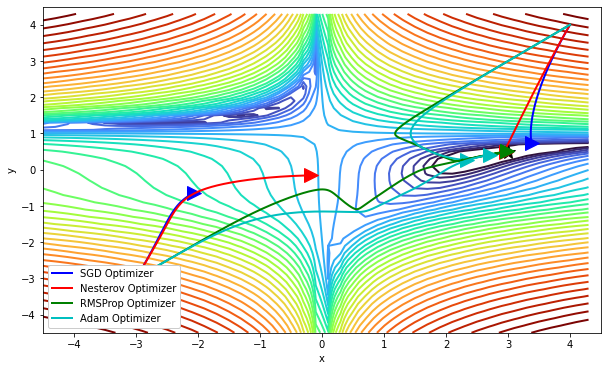

In [9]:
sgd_lr = 1e-6
rms_lr = 1e-2

optimizers = [SGD(sgd_lr), NAG(sgd_lr), RMSProp(rms_lr), Adam(rms_lr)]
positions = [(4.0, 4.0), (-3.0, -3.0)]

show_trajectories(optimizers, positions, n_epochs=10000)

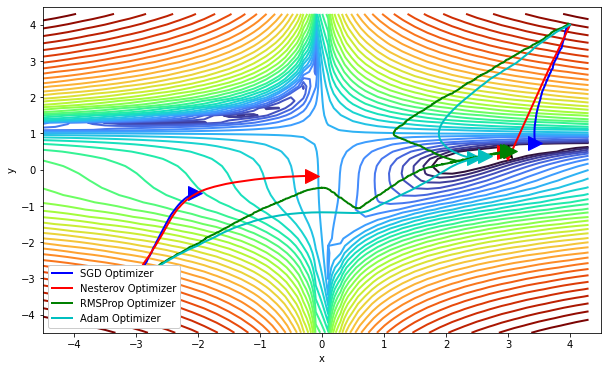

In [10]:
# Adding some noise
optimizers = [SGD(sgd_lr), NAG(sgd_lr), RMSProp(rms_lr), Adam(rms_lr)]
show_trajectories(optimizers, positions, n_epochs=10000, noise=0.5)